## Mass Mobilization Research Notebook

In [1]:
import numpy as np
import pandas as pd
import pandas_gbq 
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from pytrends.request import TrendReq

### GDelt

C:\Users\isaac\anaconda3\envs\sdc\Lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


<Axes: xlabel='MonthYear'>

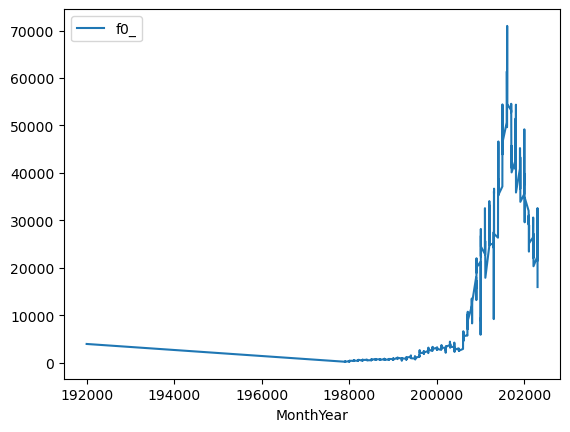

In [2]:
query = """
    SELECT MonthYear, count(*) FROM `gdelt-bq.full.events` WHERE EventBaseCode = "014" GROUP BY MonthYear ORDER BY MonthYear;
"""

event_df = pandas_gbq.read_gbq(query, project_id="gdelt-d-379201")
event_df.plot(x="MonthYear", y="f0_")

In [ ]:
query = """
    SELECT * FROM `gdelt-bq.full.events` WHERE EventBaseCode = "014";
"""

event_df = pandas_gbq.read_gbq(query, project_id="gdelt-d-379201")
event_df

Downloading:  55%|███████████████████████████████████████████████████████▏                                            |

### Google Trends

In [ ]:
def load_keywords(kw_list):
    trends = TrendReq(hl="en-US", tz=360)
    trends.build_payload(kw_list, timeframe='today 5-y')
    kw_trend_df = trends.interest_over_time()
    
    return kw_trend_df
    
def add_keywords(new_kw_list, kw_trend_df):
    new_kw_trend_df = load_keywords(new_kw_list)
    
    for col in new_kw_trend_df.columns:
        kw_trend_df[col] = new_kw_trend_df[col]
    
    return kw_trend_df
    #return kw_trend_df.merge(new_kw_trend_df)

In [ ]:
kw_trend_df = load_keywords(["blm", "defund", "abolish", "george floyd", "cats"])
kw_trend_df = add_keywords(["police", "prison", "protest", "justice", "dogs"], kw_trend_df)

In [ ]:
kw_trend_df = add_keywords(["law", "order", "trump"], kw_trend_df)

In [ ]:
kw_trend_df.plot(y=["blm", "defund", "abolish"], use_index=True)

In [ ]:
kw_trend_df.plot.scatter(y="protest", x="police")

#### Plotting as a Network

In [ ]:
SIGNIFICANCE_THRESHOLD = 0.3

def generate_correlation_graph(trend_df, autocor=False, threshold=SIGNIFICANCE_THRESHOLD):
    kw_list = list(trend_df.columns)
    kw_list.remove("isPartial")

    kws = len(kw_list)
    correlations = np.zeros((kws, kws))
    kw_net = nx.Graph()
    
    for i in range(kws):
        kw_net.add_node(i, label=kw_list[i])
        
        for j in range(kws):
                if autocor or i != j:
                    corr = kw_trend_df[kw_list[i]].corr(kw_trend_df[kw_list[j]])
                    
                    if np.isnan(corr):
                        print(kw_list[i], kw_list[j])
                    
                    if corr != 0 and not np.isnan(corr):
                        kw_net.add_edge(i, j, corr=corr, weight=np.abs(corr))
        
    return kw_net

DEFAULT_WIDTH_FN = lambda edge: 3 * edge["corr"] ** 2

def choose_color(edge):
    if edge["corr"] > 0:
        return "lightgreen"
    else:
        return "red"

def draw(graph, layout=nx.spring_layout, width_fn=DEFAULT_WIDTH_FN):
    pos = layout(graph)
    edges = graph.edges()
    weights = [width_fn(graph[i][j]) for i,j in edges]
    edge_colors = [choose_color(graph[i][j]) for i,j in edges]
    labels = nx.get_node_attributes(graph, "label")

    nx.draw_networkx_labels(kw_net, pos, labels=labels)
    nx.draw(
        graph,
        pos,
        width=list(weights),
        node_color="lightgrey",
        edge_color=edge_colors
    )

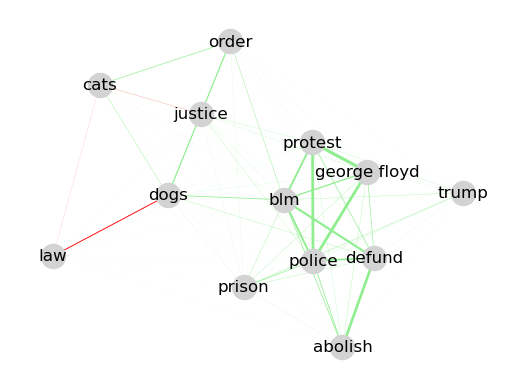

In [9]:
kw_net = generate_correlation_graph(kw_trend_df, threshold=0)
draw(kw_net, layout=nx.spring_layout)

### C-SPAN

#### Converting C-SPAN to C-TRENDS

In [ ]:
filename = ''

chunksize = 10 ** 6

output = pd.DataFrame()

with pd.read_csv(filename, chunksize=chunksize) as reader:
    for chunk in reader:
        outputChunk = chunk.apply(wordcounter(), axis = 1)
        outputChunk = outputChunk.drop("speech", axis = 1)
        output = output.append(outputChunk)
        
def wordcounter(phrases=None):
    def wordcounts(row):
        words = row["speech"].split()
        for word in words:
            if row[word] is not None:
                row[word] += 1
            elif:
                row[word] = 0
                
    return wordcounts

                